# Big Data Project - Group Eta

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageOps
#import joblib

from pyspark import SparkContext
from pyspark import SparkFiles
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, FloatType

from skimage.util.shape import view_as_windows
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import tensorflow as tf
from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [2]:
#changing the directory to the directory that has our data
os.chdir("D:/big_data/hadoop_big_data_processing_files")

In [3]:
#checking if we in the correct directory
os.getcwd()

'D:\\big_data\\hadoop_big_data_processing_files'

In [4]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is FE59-EB90

 Directory of D:\big_data\hadoop_big_data_processing_files

2020/08/08  18:17    <DIR>          .
2020/08/08  18:17    <DIR>          ..
2020/08/08  06:18         3ÿ725ÿ171 images_flatten.txt
2020/08/09  06:04    <DIR>          models
2020/08/08  08:10         4ÿ328ÿ563 test_sequence_length_12_months_ahead_1.txt
2020/08/08  08:12         4ÿ214ÿ486 test_sequence_length_12_months_ahead_2.txt
2020/08/08  08:15         4ÿ100ÿ353 test_sequence_length_12_months_ahead_3.txt
2020/08/08  08:07         2ÿ326ÿ089 test_sequence_length_4_months_ahead_1.txt
2020/08/08  08:10         2ÿ275ÿ307 test_sequence_length_4_months_ahead_2.txt
2020/08/08  08:13         2ÿ224ÿ627 test_sequence_length_4_months_ahead_3.txt
2020/08/08  08:08         3ÿ453ÿ723 test_sequence_length_8_months_ahead_1.txt
2020/08/08  08:11         3ÿ371ÿ409 test_sequence_length_8_months_ahead_2.txt
2020/08/08  08:14         3ÿ289ÿ140 test_sequence_length_8_months_ahe

# Ingest Data to the HDFS

In [5]:
#first create the directory
!hadoop fs -mkdir /big_data

In [6]:
#we list the files in hadoop_bdp_data directory to see what files it consists of. It shouldn't contain anything 
#we can see that we created the folder
!hadoop fs -ls /

Found 1 items
drwxr-xr-x   - admin supergroup          0 2020-08-09 08:44 /big_data


In [7]:
#lets copy all the csv files from the local Hadoop_Big_Data_Processing_Files directory to the HDFS hadoop_bdp_data directory
!hadoop fs -put * /big_data

In [8]:
#we confirm our above action
!hadoop fs -ls /big_data

Found 20 items
-rw-r--r--   1 admin supergroup    3725171 2020-08-09 08:44 /big_data/images_flatten.txt
drwxr-xr-x   - admin supergroup          0 2020-08-09 08:44 /big_data/models
-rw-r--r--   1 admin supergroup    4328563 2020-08-09 08:44 /big_data/test_sequence_length_12_months_ahead_1.txt
-rw-r--r--   1 admin supergroup    4214486 2020-08-09 08:44 /big_data/test_sequence_length_12_months_ahead_2.txt
-rw-r--r--   1 admin supergroup    4100353 2020-08-09 08:44 /big_data/test_sequence_length_12_months_ahead_3.txt
-rw-r--r--   1 admin supergroup    2326089 2020-08-09 08:44 /big_data/test_sequence_length_4_months_ahead_1.txt
-rw-r--r--   1 admin supergroup    2275307 2020-08-09 08:44 /big_data/test_sequence_length_4_months_ahead_2.txt
-rw-r--r--   1 admin supergroup    2224627 2020-08-09 08:44 /big_data/test_sequence_length_4_months_ahead_3.txt
-rw-r--r--   1 admin supergroup    3453723 2020-08-09 08:44 /big_data/test_sequence_length_8_months_ahead_1.txt
-rw-r--r--   1 admin supergroup 

In [9]:
#viewing the contents of one of the files
!hadoop fs -tail /big_data/test_sequence_length_4_months_ahead_1.txt

0
73565,33.0,35.0,47.0,44.0,70.0
73566,25.0,27.0,36.0,35.0,56.0
73567,2.0,2.0,3.0,3.0,5.0
73568,0.0,0.0,0.0,0.0,0.0
73569,0.0,0.0,0.0,0.0,0.0
73570,0.0,0.0,0.0,0.0,0.0
73571,0.0,0.0,0.0,0.0,0.0
73572,0.0,0.0,0.0,0.0,0.0
73573,0.0,0.0,0.0,0.0,0.0
73574,0.0,0.0,0.0,0.0,0.0
73575,0.0,0.0,0.0,0.0,0.0
73576,0.0,0.0,0.0,0.0,0.0
73577,0.0,0.0,0.0,0.0,0.0
73578,0.0,0.0,0.0,0.0,0.0
73579,0.0,0.0,0.0,0.0,0.0
73580,0.0,0.0,0.0,0.0,0.0
73581,0.0,0.0,0.0,0.0,0.0
73582,0.0,0.0,0.0,0.0,0.0
73583,0.0,0.0,0.0,0.0,0.0
73584,0.0,0.0,0.0,0.0,0.0
73585,0.0,0.0,0.0,0.0,0.0
73586,0.0,0.0,0.0,0.0,0.0
73587,1.0,1.0,1.0,2.0,4.0
73588,21.0,24.0,27.0,62.0,137.0
73589,31.0,35.0,37.0,91.0,199.0
73590,30.0,32.0,33.0,93.0,200.0
73591,30.0,33.0,33.0,95.0,175.0
73592,30.0,32.0,32.0,95.0,140.0
73593,30.0,31.0,33.0,85.0,117.0
73594,30.0,31.0,32.0,66.0,84.0
73595,30.0,31.0,33.0,56.0,63.0
73596,30.0,31.0,34.0,51.0,57.0
73597,30.0,32.0,34.0,50.0,57.0
73598,31.0,34.0,34.0,55.0,61.0
73599,31.0,34.0,36.0,62.0,65.0


# Getting Data From HDFS

In [10]:
spark = SparkContext.getOrCreate()
spark.stop()

In [11]:
#creating spark, streaming and SQL context so that we can get the data from Hadoop using Spark
spark_context = SparkContext().getOrCreate()
sqlContext = SQLContext(spark_context)

In [12]:
#printing the spark context so that we can go to the URL of spark and get if our data has been ingested into spark
spark_context

<SparkContext master=local[*] appName=pyspark-shell>

In [13]:
#gettting the files from our HDFS big_data folder to our spark context
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_4_months_ahead_1.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_8_months_ahead_1.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_12_months_ahead_1.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_4_months_ahead_1.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_8_months_ahead_1.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_12_months_ahead_1.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_4_months_ahead_2.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_8_months_ahead_2.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_12_months_ahead_2.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_4_months_ahead_2.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_8_months_ahead_2.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_12_months_ahead_2.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_4_months_ahead_3.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_8_months_ahead_3.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/train_sequence_length_12_months_ahead_3.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_4_months_ahead_3.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_8_months_ahead_3.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/test_sequence_length_12_months_ahead_3.txt')
spark_context.addFile('hdfs://localhost:9000//big_data/images_flatten.txt')

In [14]:
#using a spark rdd this function returns X and Y numpy arrays which represents the training/testing data and its ground truth values
def create_dataset(rdd, length, seq_length):
    data = []
    rdd = rdd.map(lambda x: x.split(","))
    
    for i, sample in enumerate(rdd.take(length)):
        if i==0:
            continue
        data.append(list(map(float, sample[1:])))
    
    data = np.array(data)
    
    X = data[:, :seq_length]
    Y = data[:, seq_length:]
    
    Y = np.reshape(Y, (Y.shape[0])) 
    
    return X, Y

In [15]:
#calculates the monthly average using pyspark
def monthly_average_rainfall(rdd, length):
    data = []
    rdd = rdd.map(lambda x: x.split(",")).map(lambda x: list(map(float, x))[1:]).map(lambda x: sum(x)/len(x))
    for sample in rdd.take(length):
        data.append(sample)
    data = np.array(data)
    return data

In [16]:
#this function returns the array which consists of the last column of pixels from the X numpy array
def last_pixel(array, seq_length, length):
    result = []
    for i in range(length):
        result.append(array[i][seq_length-1])
    return result

In [17]:
#this creates a Deep LSTM model that we'll use for our predictions
def Deep_LSTM(seq_length):
    model = Sequential()
    model.add(LSTM(64, input_shape=(seq_length, 1), return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    return model

In [18]:
#this creates a Random Forest model that we'll use for our predictions
def Random_Forest(train_X, train_Y):
    model=RandomForestClassifier()
    model.fit(train_X,train_Y)
    return model

In [19]:
#this functions compares the untrained versus trained regressors and then plots these values in a table for visualization purposes
def compare_regressors(test_X, test_Y, pred, sequence_length):
    
    test_X_last_pixel = last_pixel(test_X, sequence_length, test_X.shape[0])
    test_X_last_pixel = np.array(test_X_last_pixel)

    mae_untrained = mean_absolute_error(test_Y, test_X_last_pixel)
    rmse_untrained = math.sqrt(mean_squared_error(test_Y, test_X_last_pixel))
    
    mae_trained = mean_absolute_error(test_Y, pred)
    rmse_trained = math.sqrt(mean_squared_error(test_Y, pred))
    
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    df = pd.DataFrame([[mae_untrained, rmse_untrained], [mae_trained, rmse_trained]], columns=["MAE","RMSE"], index=["untrained", "trained"])
    ax.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns, loc='center')
    plt.show()
    
    return mae_untrained, rmse_untrained, mae_trained, rmse_trained

In [20]:
#this function prints our the test images and the predicted image from either the Random Forest model or the Deep LSTM model
def compare_images(pred, test_Y, num_images):

    for i, value in enumerate(pred):
        if value < 0.0:
            pred[i] = 0.0

    y = []
    pred_images = []
    index=0
    for counter in range(num_images):
        pixel_count = 0
        while pixel_count < 1600:
            y.append(pred[index])
            pixel_count+=1
            index+=1
        pred_images.append(np.array(y).reshape(40, 40))
        y=[]

    y = []
    test_images = []
    index=0
    for counter in range(num_images):
        pixel_count = 0
        while pixel_count < 1600:
            y.append(test_Y[index])
            pixel_count+=1
            index+=1
        test_images.append(np.array(y).reshape(40, 40))
        y=[]
    
    pics_per_row = 2
    plt.figure(figsize=(pics_per_row*3.5, num_images*3.5))
        
    for i in range(num_images*pics_per_row):
        plt.subplot(num_images,pics_per_row,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if (i%2)==0:
            plt.imshow(test_images[int(i/2)], cmap='gray')
            plt.xlabel("Test Image")
        else:
            plt.imshow(pred_images[int(i/2)], cmap='gray')
            plt.xlabel("Prediction Image")
    plt.show()

# Visualizing Average Monthly Rainfall

Computing averages using Map Reduce

Visualizing the average rainfall for each month using pyspark

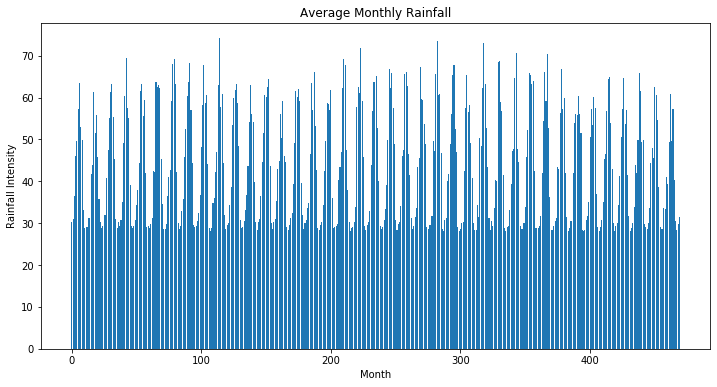

In [21]:
#calculating the average rainfall for each month using pyspark
train_rdd = spark_context.textFile(SparkFiles.get('images_flatten.txt'))
length = train_rdd.count()
monthly_averages= monthly_average_rainfall(train_rdd, length)
x = np.arange(0, monthly_averages.shape[0])

fig = plt.figure(figsize=(12,6))
plt.bar(x, monthly_averages)
plt.xlabel('Month')
plt.ylabel('Rainfall Intensity')
plt.title("Average Monthly Rainfall")
#plt.savefig("D:/big_data/final_2/pics/Average Monthly Rainfall", transparent=True)
plt.show()

In [22]:
'''
!hadoop jar C:/work/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar \
  -files "hdfs:///big_data/mapper.py,hdfs:///big_data/reducer.py"\
  -mapper "python mapper.py" \
  -reducer "python reducer.py" \
  -input /big_data/images_flatten.txt \
  -output /big_data/averages 
'''

'\n!hadoop jar C:/work/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar   -files "hdfs:///big_data/mapper.py,hdfs:///big_data/reducer.py"  -mapper "python mapper.py"   -reducer "python reducer.py"   -input /big_data/images_flatten.txt   -output /big_data/averages \n'

# 1 Month Ahead | Sequence Length = 4

### Random Forest Regressor

##### Creating Train & Test Datasets

In [23]:
#1 month ahead, sequence length of 4

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_4_months_ahead_1.txt'))
length = train_rdd.count() #returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 4) #creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_4_months_ahead_1.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 4)#creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(153600, 4)
(153600,)
(73600, 4)
(73600,)


In [24]:
data = []
test_rdd = test_rdd.map(lambda x: x.split(","))
    
for i, sample in enumerate(test_rdd.take(length)):
    if i==0:
        continue
    data.append(list(map(float, sample[1:])))
data = np.array(data)
print(data)

[[34. 38. 47. 55. 39.]
 [35. 40. 50. 55. 40.]
 [35. 39. 50. 56. 40.]
 ...
 [30. 32. 34. 50. 57.]
 [31. 34. 34. 55. 61.]
 [31. 34. 36. 62. 65.]]


##### Training Model

In [25]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_4_1.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_4_1.joblib")


In [26]:
model.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

##### Predicting on Test dataset

In [27]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

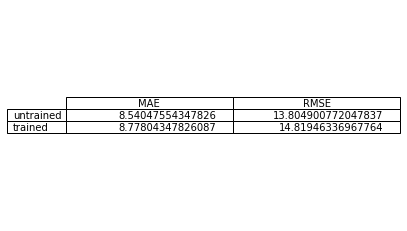

In [28]:
rf_mae_untrained_4_1, rf_rmse_untrained_4_1, rf_mae_trained_4_1, rf_rmse_trained_4_1 = compare_regressors(test_X, test_Y, pred, 4)

##### Comparing Images

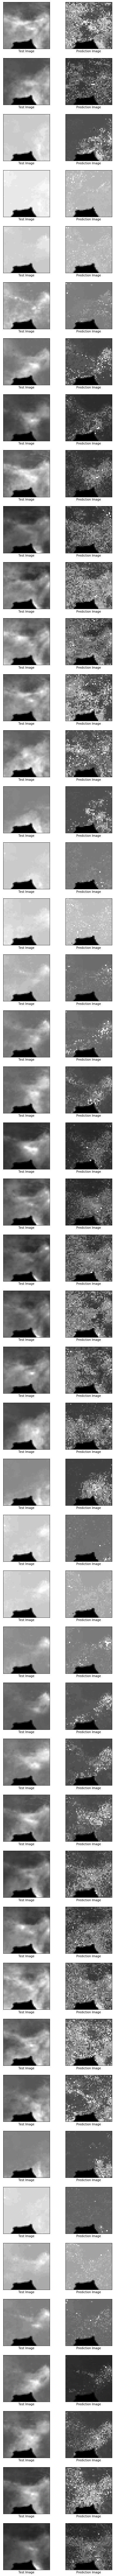

In [29]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [30]:
#1 month ahead, sequence length of 4

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_4_months_ahead_1.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 4)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_4_months_ahead_1.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 4) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(153600, 4, 1)
(153600,)
(73600, 4, 1)
(73600,)


##### Training Model

In [31]:
#model = Deep_LSTM(4)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [32]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_4_1')

model = load_model('/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_4_1')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
73600/73600 [==============================] - 4s 58us/sample - loss: 7.0196 - root_mean_squared_error: 11.6820


##### Comparing Untrained Regressor vs Trained Regressor 

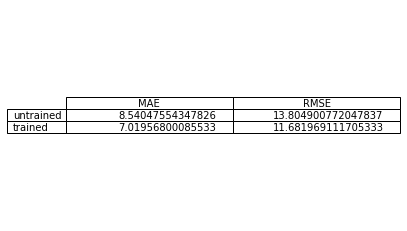

In [33]:
lstm_mae_untrained_4_1, lstm_rmse_untrained_4_1, lstm_mae_trained_4_1, lstm_rmse_trained_4_1 = compare_regressors(test_X, test_Y, pred, 4)

##### Comparing Images

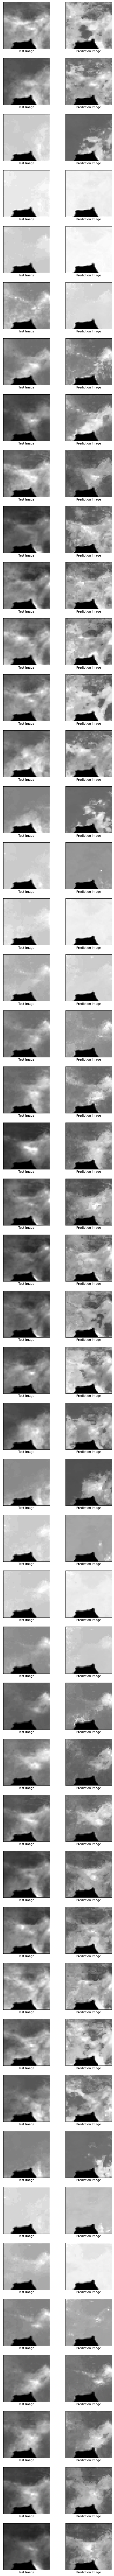

In [34]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 1 Month Ahead | Sequence Length = 8

### Random Forest Regressor

##### Creating Train & Test Datasets

In [35]:
#1 month ahead, sequence length of 8

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_8_months_ahead_1.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 8)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_8_months_ahead_1.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 8) #creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(147200, 8)
(147200,)
(67200, 8)
(67200,)


##### Training Model

In [36]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_8_1.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_8_1.joblib")

##### Predicting on Test dataset

In [37]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

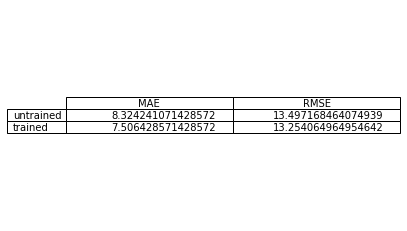

In [38]:
rf_mae_untrained_8_1, rf_rmse_untrained_8_1, rf_mae_trained_8_1, rf_rmse_trained_8_1 = compare_regressors(test_X, test_Y, pred, 8)

##### Comparing Images

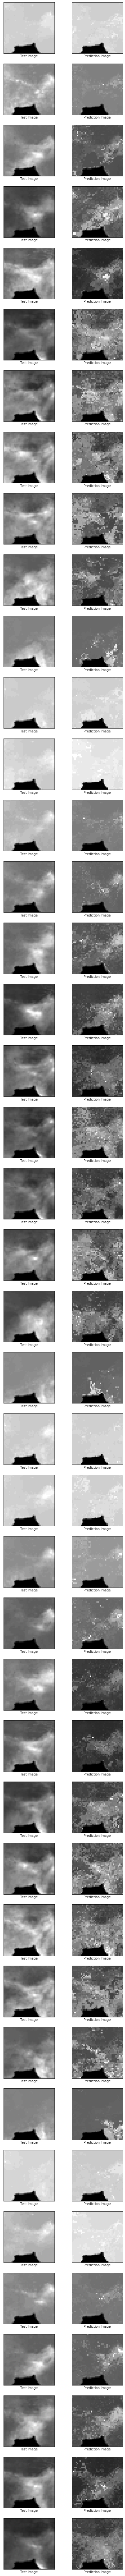

In [39]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [40]:
#1 month ahead, sequence length of 8

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_8_months_ahead_1.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 8)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_8_months_ahead_1.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 8) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(147200, 8, 1)
(147200,)
(67200, 8, 1)
(67200,)


##### Training Model

In [41]:
#model = Deep_LSTM(8)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [42]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_8_1')

model = load_model('/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_8_1')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

67200/67200 [==============================] - 7s 104us/sample - loss: 6.7349 - root_mean_squared_error: 11.3556


##### Comparing Untrained Regressor vs Trained Regressor 

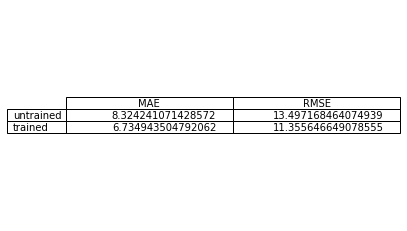

In [43]:
lstm_mae_untrained_8_1, lstm_rmse_untrained_8_1, lstm_mae_trained_8_1, lstm_rmse_trained_8_1 = compare_regressors(test_X, test_Y, pred, 8)

##### Comparing Images

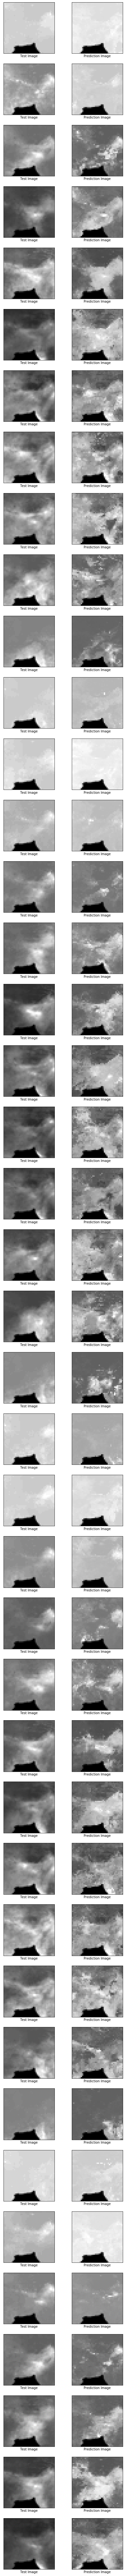

In [44]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 1 Month Ahead | Sequence Length = 12

### Random Forest Regressor

##### Creating Train & Test Datasets

In [45]:
#1 month ahead, sequence length of 12

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_12_months_ahead_1.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 12)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_12_months_ahead_1.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 12) #creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(140800, 12)
(140800,)
(60800, 12)
(60800,)


##### Training Model

In [46]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_12_1.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_12_1.joblib")

##### Predicting on Test dataset

In [47]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

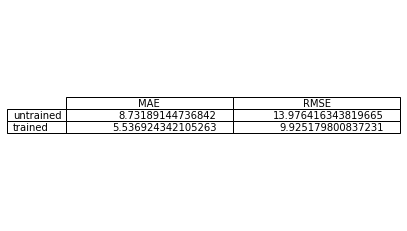

In [48]:
rf_mae_untrained_12_1, rf_rmse_untrained_12_1, rf_mae_trained_12_1, rf_rmse_trained_12_1 = compare_regressors(test_X, test_Y, pred, 12)

##### Comparing Images

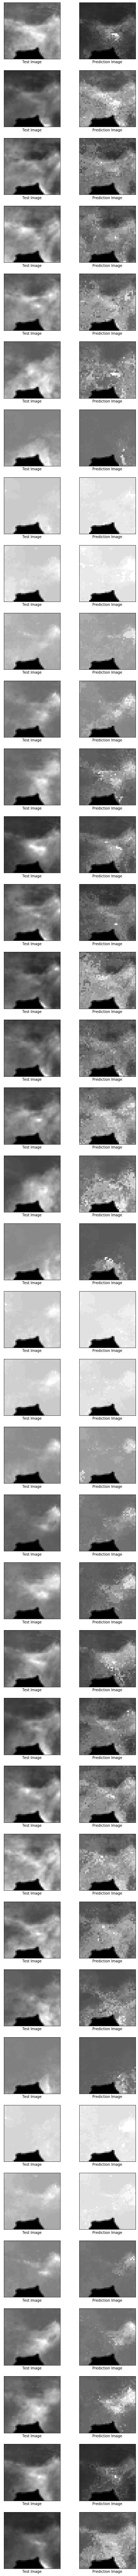

In [49]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [50]:
#1 month ahead, sequence length of 12

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_12_months_ahead_1.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 12)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_12_months_ahead_1.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 12) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(140800, 12, 1)
(140800,)
(60800, 12, 1)
(60800,)


##### Training Model

In [51]:
#model = Deep_LSTM(12)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [52]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_12_1')

model = load_model('/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_12_1')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

60800/60800 [==============================] - 12s 193us/sample - loss: 5.4175 - root_mean_squared_error: 9.2721


##### Comparing Untrained Regressor vs Trained Regressor 

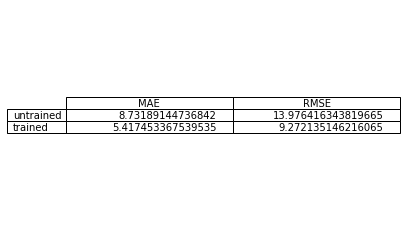

In [53]:
lstm_mae_untrained_12_1, lstm_rmse_untrained_12_1, lstm_mae_trained_12_1, lstm_rmse_trained_12_1 = compare_regressors(test_X, test_Y, pred, 12)

##### Comparing Images

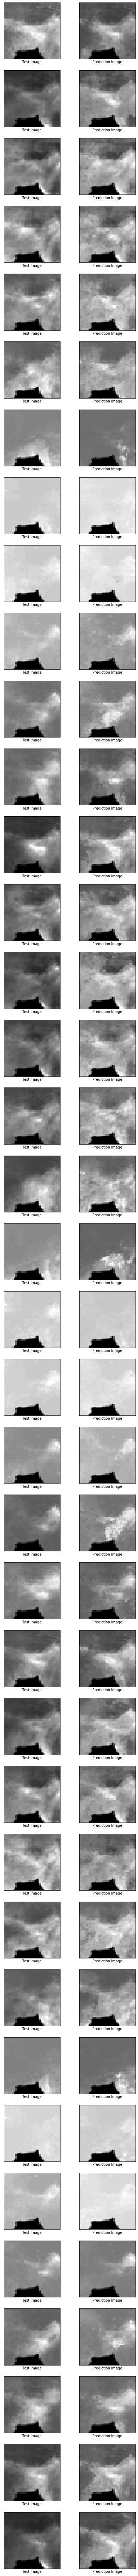

In [54]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 2 Months Ahead | Sequence Length = 4

### Random Forest Regressor

##### Creating Train & Test Datasets

In [55]:
#2 months ahead, sequence length of 4

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_4_months_ahead_2.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 4)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_4_months_ahead_2.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 4) #creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(152000, 4)
(152000,)
(72000, 4)
(72000,)


##### Training Model

In [56]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_4_2.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_4_2.joblib")

##### Predicting on Test dataset

In [57]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

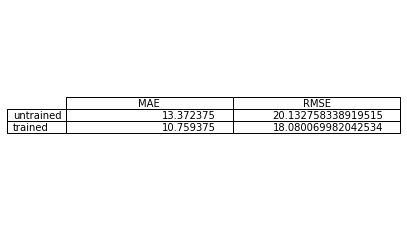

In [58]:
rf_mae_untrained_4_2, rf_rmse_untrained_4_2, rf_mae_trained_4_2, rf_rmse_trained_4_2 = compare_regressors(test_X, test_Y, pred, 4)

##### Comparing Images

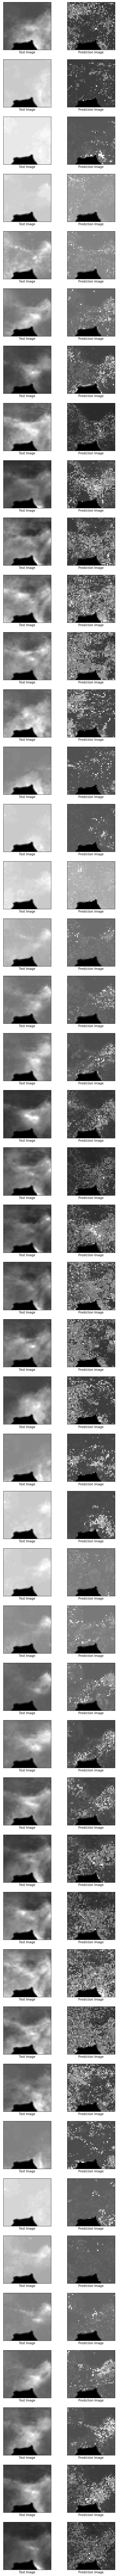

In [59]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [60]:
#2 months ahead, sequence length of 4

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_4_months_ahead_2.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 4)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_4_months_ahead_2.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 4) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(152000, 4, 1)
(152000,)
(72000, 4, 1)
(72000,)


##### Training Model

In [61]:
#model = Deep_LSTM(4)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [62]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_4_2')

model = load_model('/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_4_2')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

72000/72000 [==============================] - 7s 102us/sample - loss: 8.8156 - root_mean_squared_error: 14.8840


##### Comparing Untrained Regressor vs Trained Regressor 

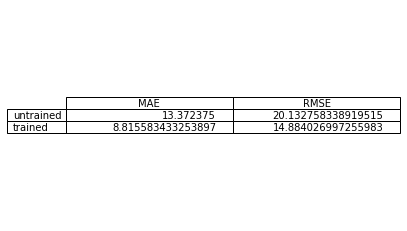

In [63]:
lstm_mae_untrained_4_2, lstm_rmse_untrained_4_2, lstm_mae_trained_4_2, lstm_rmse_trained_4_2 = compare_regressors(test_X, test_Y, pred, 4)

##### Comparing Images

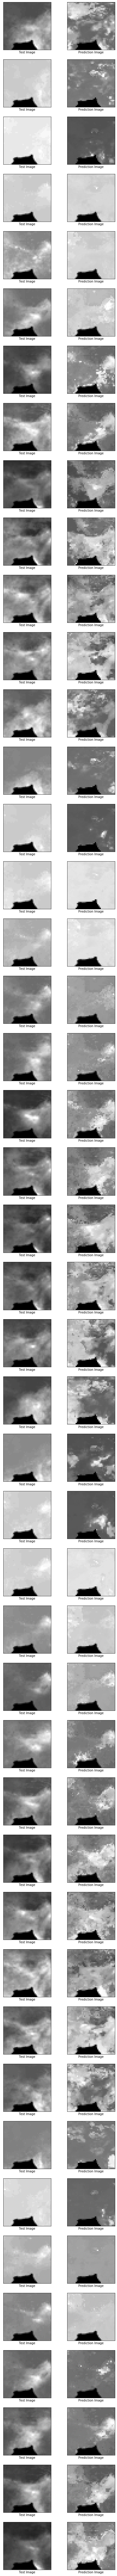

In [64]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 2 Months Ahead | Sequence Length = 8

### Random Forest Regressor

##### Creating Train & Test Datasets

In [65]:
#2 months ahead, sequence length of 8

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_8_months_ahead_2.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 8)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_8_months_ahead_2.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 8) #creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(145600, 8)
(145600,)
(65600, 8)
(65600,)


##### Training Model

In [66]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_8_2.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_8_2.joblib")

##### Predicting on Test dataset

In [67]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

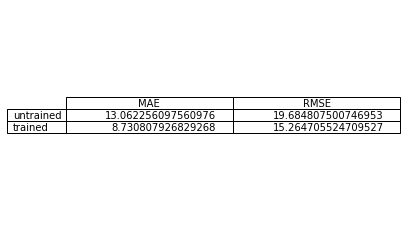

In [68]:
rf_mae_untrained_8_2, rf_rmse_untrained_8_2, rf_mae_trained_8_2, rf_rmse_trained_8_2 = compare_regressors(test_X, test_Y, pred, 8)

##### Comparing Images

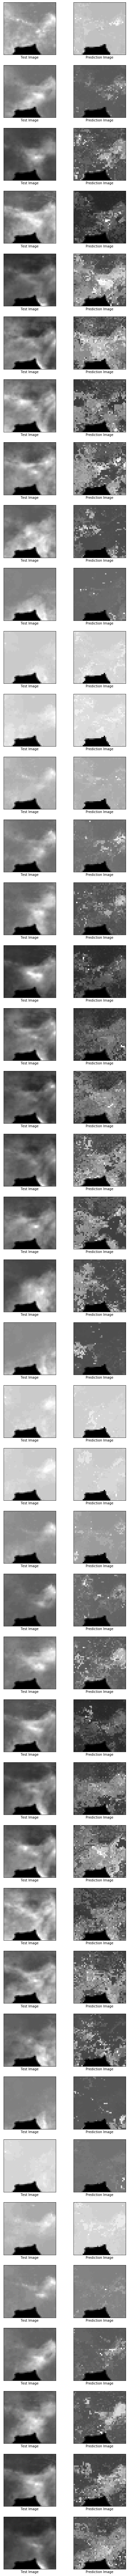

In [69]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [70]:
#2 months ahead, sequence length of 8

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_8_months_ahead_2.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 8)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_8_months_ahead_2.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 8)#creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(145600, 8, 1)
(145600,)
(65600, 8, 1)
(65600,)


##### Training Model

In [71]:
#model = Deep_LSTM(8)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [72]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_8_2')

model = load_model('/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_8_2')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

65600/65600 [==============================] - 14s 210us/sample - loss: 7.7643 - root_mean_squared_error: 13.0495


##### Comparing Untrained Regressor vs Trained Regressor 

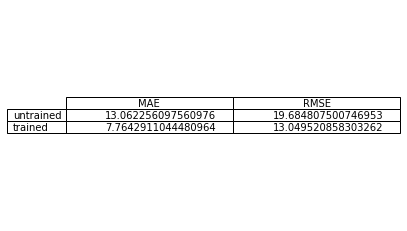

In [73]:
lstm_mae_untrained_8_2, lstm_rmse_untrained_8_2, lstm_mae_trained_8_2, lstm_rmse_trained_8_2 = compare_regressors(test_X, test_Y, pred, 8)

##### Comparing Images

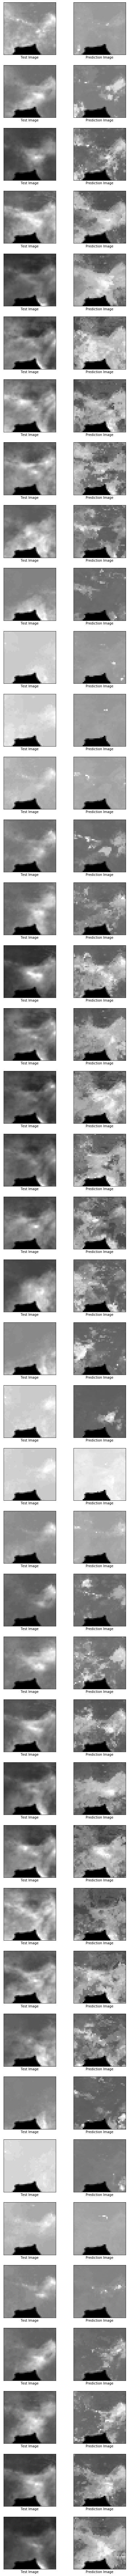

In [74]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 2 Months Ahead | Sequence Length = 12

### Random Forest Regressor

##### Creating Train & Test Datasets

In [75]:
#2 months ahead, sequence length of 12

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_12_months_ahead_2.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 12)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_12_months_ahead_2.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 12) #creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(139200, 12)
(139200,)
(59200, 12)
(59200,)


##### Training Model

In [76]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_12_2.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_12_2.joblib")

##### Predicting on Test dataset

In [77]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

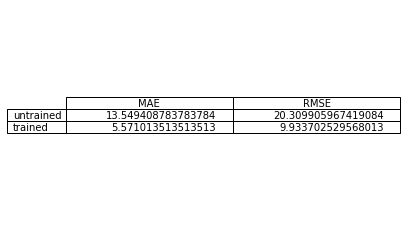

In [78]:
rf_mae_untrained_12_2, rf_rmse_untrained_12_2, rf_mae_trained_12_2, rf_rmse_trained_12_2 = compare_regressors(test_X, test_Y, pred, 12)

##### Comparing Images

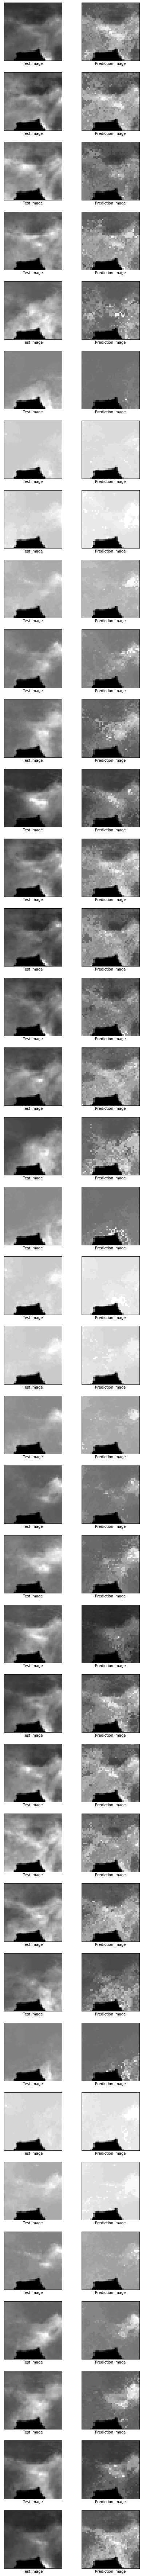

In [79]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [80]:
#2 months ahead, sequence length of 12

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_12_months_ahead_2.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 12)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_12_months_ahead_2.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 12) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(139200, 12, 1)
(139200,)
(59200, 12, 1)
(59200,)


##### Training Model

In [81]:
#model = Deep_LSTM(12)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [82]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_12_2')

model = load_model('/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_12_2')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

59200/59200 [==============================] - 25s 416us/sample - loss: 5.5970 - root_mean_squared_error: 9.6742


##### Comparing Untrained Regressor vs Trained Regressor 

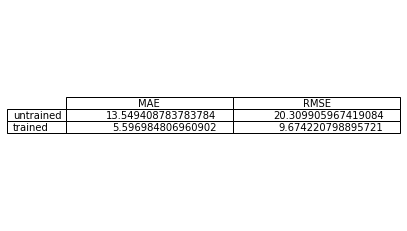

In [83]:
lstm_mae_untrained_12_2, lstm_rmse_untrained_12_2, lstm_mae_trained_12_2, lstm_rmse_trained_12_2 = compare_regressors(test_X, test_Y, pred, 12)

##### Comparing Images

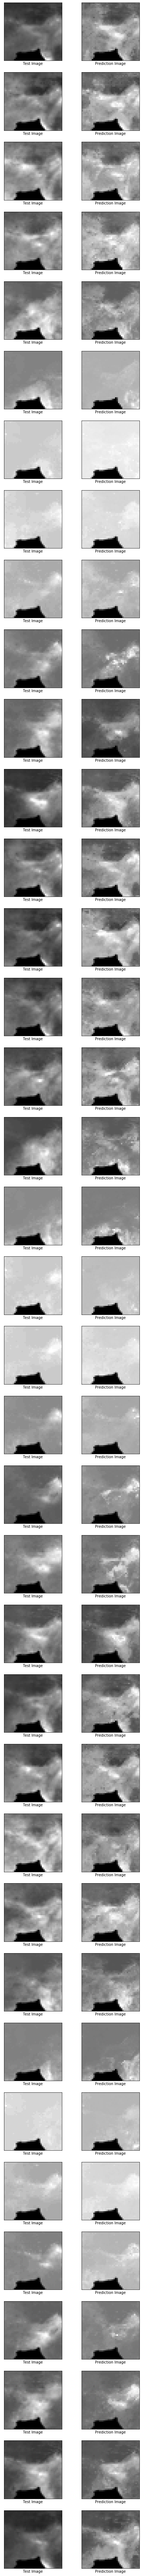

In [84]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 3 Months Ahead | Sequence Length = 4

### Random Forest Regressor

##### Creating Train & Test Datasets

In [85]:
#3 months ahead, sequence length of 4

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_4_months_ahead_3.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 4)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_4_months_ahead_3.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 4) #creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(150400, 4)
(150400,)
(70400, 4)
(70400,)


##### Training Model

In [86]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_4_3.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_4_3.joblib")

##### Predicting on Test dataset

In [87]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

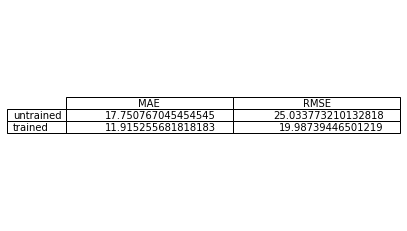

In [88]:
rf_mae_untrained_4_3, rf_rmse_untrained_4_3, rf_mae_trained_4_3, rf_rmse_trained_4_3 = compare_regressors(test_X, test_Y, pred, 4)

##### Comparing Images

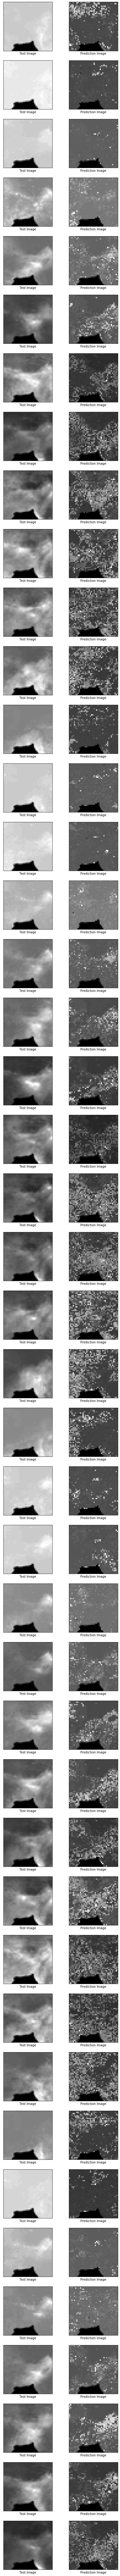

In [89]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [90]:
#3 months ahead, sequence length of 4

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_4_months_ahead_3.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 4)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_4_months_ahead_3.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 4) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(150400, 4, 1)
(150400,)
(70400, 4, 1)
(70400,)


##### Training Model

In [91]:
#model = Deep_LSTM(4)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [92]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_4_3')

model = load_model('/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_4_3')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

70400/70400 [==============================] - 14s 192us/sample - loss: 9.7888 - root_mean_squared_error: 16.2530


##### Comparing Untrained Regressor vs Trained Regressor 

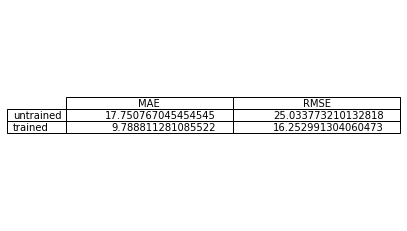

In [93]:
lstm_mae_untrained_4_3, lstm_rmse_untrained_4_3, lstm_mae_trained_4_3, lstm_rmse_trained_4_3 = compare_regressors(test_X, test_Y, pred, 4)

##### Comparing Images

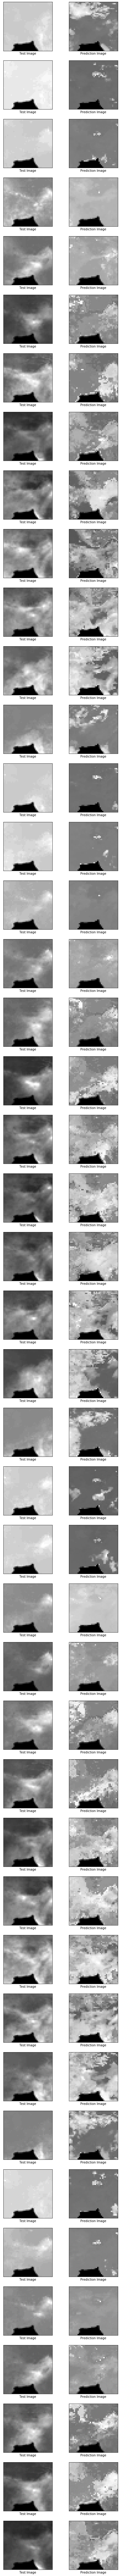

In [94]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 3 Months Ahead | Sequence Length = 8

### Random Forest Regressor

##### Creating Train & Test Datasets

In [95]:
#3 months ahead, sequence length of 8

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_8_months_ahead_3.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 8)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_8_months_ahead_3.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 8) #creates a testing X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(144000, 8)
(144000,)
(64000, 8)
(64000,)


##### Training Model

In [96]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_8_3.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_8_3.joblib")

##### Predicting on Test dataset

In [97]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

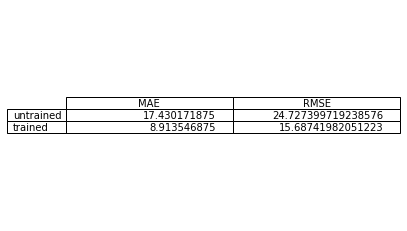

In [98]:
rf_mae_untrained_8_3, rf_rmse_untrained_8_3, rf_mae_trained_8_3, rf_rmse_trained_8_3 = compare_regressors(test_X, test_Y, pred, 8)

##### Comparing Images

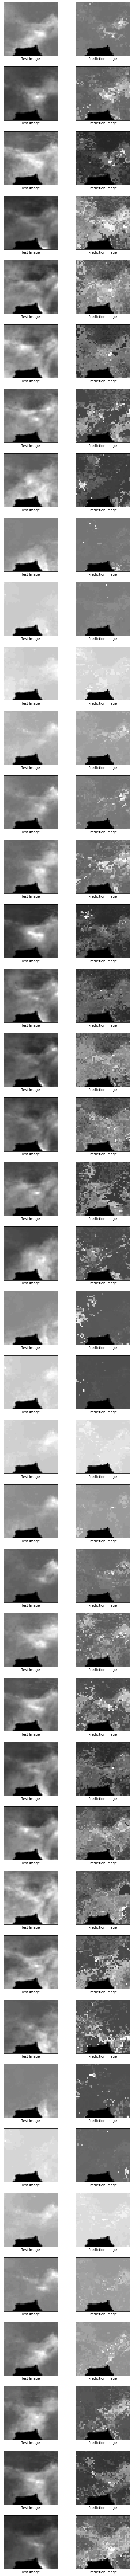

In [99]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [100]:
#3 months ahead, sequence length of 8

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_8_months_ahead_3.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 8)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_8_months_ahead_3.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 8) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(144000, 8, 1)
(144000,)
(64000, 8, 1)
(64000,)


##### Training Model

In [101]:
#model = Deep_LSTM(8)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [102]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_8_3')

model = load_model('D:/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_8_3')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

64000/64000 [==============================] - 25s 383us/sample - loss: 8.2223 - root_mean_squared_error: 13.6619


##### Comparing Untrained Regressor vs Trained Regressor 

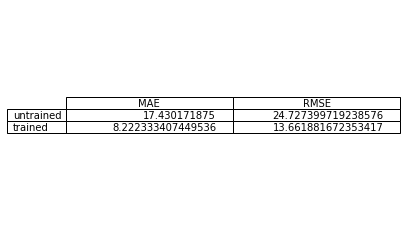

In [103]:
lstm_mae_untrained_8_3, lstm_rmse_untrained_8_3, lstm_mae_trained_8_3, lstm_rmse_trained_8_3 = compare_regressors(test_X, test_Y, pred, 8)

##### Comparing Images

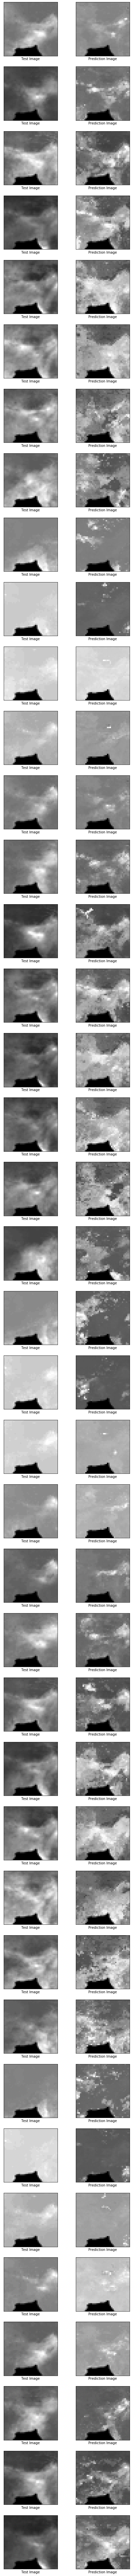

In [104]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# 3 Months Ahead | Sequence Length = 12

### Random Forest Regressor

##### Creating Train & Test Datasets

In [105]:
#3 months ahead, sequence length of 12

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_12_months_ahead_3.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 12)

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_12_months_ahead_3.txt'))
length = test_rdd.count() #returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 12) #creates a training X and Y dataset using the create_dataset function

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(137600, 12)
(137600,)
(57600, 12)
(57600,)


##### Training Model

In [106]:
model = Random_Forest(train_X, train_Y)
#joblib.dump(model, "D:/big_data/Model/random_forest_12_3.joblib",compress=3)
#model = joblib.load("D:/big_data/Model/random_forest_12_3.joblib")

##### Predicting on Test dataset

In [107]:
pred = model.predict(test_X)

##### Comparing Untrained Regressor vs Trained Regressor 

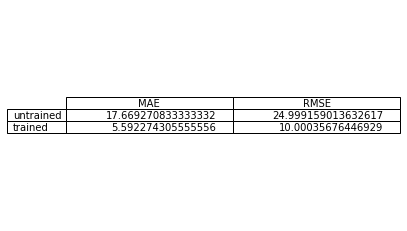

In [108]:
rf_mae_untrained_12_3, rf_rmse_untrained_12_3, rf_mae_trained_12_3, rf_rmse_trained_12_3 = compare_regressors(test_X, test_Y, pred, 12)

##### Comparing Images

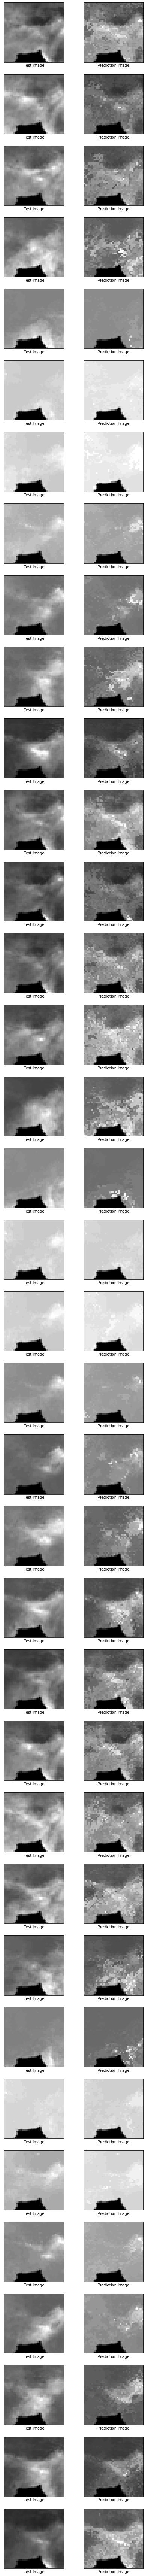

In [109]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

### Deep LSTM Regressor

##### Creating Train & Test Datasets

In [110]:
#3 months ahead, sequence length of 12

#getting the data from spark and then storing it in a RDD.
train_rdd = spark_context.textFile(SparkFiles.get('train_sequence_length_12_months_ahead_3.txt'))
length = train_rdd.count()#returns the length of the RDD
train_X, train_Y = create_dataset(train_rdd, length, 12)#creates a training X and Y dataset using the create_dataset function

#getting the data from spark and then storing it in a RDD.
test_rdd = spark_context.textFile(SparkFiles.get('test_sequence_length_12_months_ahead_3.txt'))
length = test_rdd.count()#returns the length of the RDD
test_X, test_Y = create_dataset(test_rdd, length, 12) #creates a testing X and Y dataset using the create_dataset function

#reshaping the training and testing X arrays to the format required for deep learning
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(137600, 12, 1)
(137600,)
(57600, 12, 1)
(57600,)


##### Training Model

In [111]:
#model = Deep_LSTM(12)
#model.fit(train_X, train_Y, epochs=15, validation_split=0.2, batch_size=8, verbose=1)

##### Saving, Loading Model & Predicting on Test Dataset

In [112]:
#dirs = os.listdir()
#if 'models' not in dirs:
#    os.makedirs('models')
    
#model.save('models/Deep_LSTM_12_3')

model = load_model('D:/big_data/hadoop_big_data_processing_files/models/Deep_LSTM_12_3')

model.evaluate(test_X, test_Y)

pred = model.predict(test_X)

57600/57600 [==============================] - 35s 610us/sample - loss: 5.9033 - root_mean_squared_error: 10.0494


##### Comparing Untrained Regressor vs Trained Regressor 

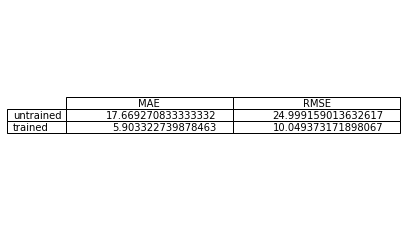

In [113]:
lstm_mae_untrained_12_3, lstm_rmse_untrained_12_3, lstm_mae_trained_12_3, lstm_rmse_trained_12_3 = compare_regressors(test_X, test_Y, pred, 12)

##### Comparing Images

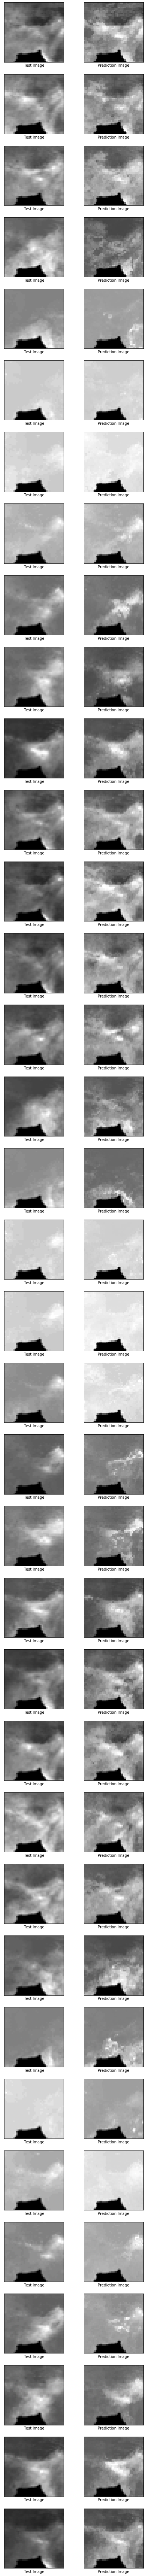

In [114]:
num_images = int(test_Y.shape[0]/1600)
compare_images(pred, test_Y, num_images)

# Analysis Using PySpark

In [115]:
#creating a list with the name of trained model, the sequence length, number of months ahead, its associated mae trained value and its associated rmse trained value

results =[("Random Forest", 4, 1, rf_mae_trained_4_1.item(), rf_rmse_trained_4_1),
          ("Random Forest", 4, 2, rf_mae_trained_4_2.item(), rf_rmse_trained_4_2), 
          ("Random Forest", 4, 3, rf_mae_trained_4_3.item(), rf_rmse_trained_4_3),
          ("Random Forest", 8, 1, rf_mae_trained_8_1.item(), rf_rmse_trained_8_1),
          ("Random Forest", 8, 2, rf_mae_trained_8_2.item(), rf_rmse_trained_8_2), 
          ("Random Forest", 8, 3, rf_mae_trained_8_3.item(), rf_rmse_trained_8_3),
          ("Random Forest", 12, 1, rf_mae_trained_12_1.item(), rf_rmse_trained_12_1),
          ("Random Forest", 12, 2, rf_mae_trained_12_2.item(), rf_rmse_trained_12_2), 
          ("Random Forest", 12, 3, rf_mae_trained_12_3.item(), rf_rmse_trained_12_3),
          ("Deep LSTM", 4, 1, lstm_mae_trained_4_1.item(), lstm_rmse_trained_4_1),
          ("Deep LSTM", 4, 2, lstm_mae_trained_4_2.item(), lstm_rmse_trained_4_2), 
          ("Deep LSTM", 4, 3, lstm_mae_trained_4_3.item(), lstm_rmse_trained_4_3),
          ("Deep LSTM", 8, 1, lstm_mae_trained_8_1.item(), lstm_rmse_trained_8_1),
          ("Deep LSTM", 8, 2, lstm_mae_trained_8_2.item(), lstm_rmse_trained_8_2), 
          ("Deep LSTM", 8, 3, lstm_mae_trained_8_3.item(), lstm_rmse_trained_8_3),
          ("Deep LSTM", 12, 1, lstm_mae_trained_12_1.item(), lstm_rmse_trained_12_1),
          ("Deep LSTM", 12, 2, lstm_mae_trained_12_2.item(), lstm_rmse_trained_12_2), 
          ("Deep LSTM", 12, 3, lstm_mae_trained_12_3.item(), lstm_rmse_trained_12_3)]
results


[('Random Forest', 4, 1, 8.77804347826087, 14.81946336967764),
 ('Random Forest', 4, 2, 10.759375, 18.080069982042534),
 ('Random Forest', 4, 3, 11.915255681818183, 19.98739446501219),
 ('Random Forest', 8, 1, 7.506428571428572, 13.254064964954642),
 ('Random Forest', 8, 2, 8.730807926829268, 15.264705524709527),
 ('Random Forest', 8, 3, 8.913546875, 15.68741982051223),
 ('Random Forest', 12, 1, 5.536924342105263, 9.925179800837231),
 ('Random Forest', 12, 2, 5.571013513513513, 9.933702529568013),
 ('Random Forest', 12, 3, 5.592274305555556, 10.00035676446929),
 ('Deep LSTM', 4, 1, 7.01956800085533, 11.681969111705333),
 ('Deep LSTM', 4, 2, 8.815583433253897, 14.884026997255983),
 ('Deep LSTM', 4, 3, 9.788811281085522, 16.252991304060473),
 ('Deep LSTM', 8, 1, 6.734943504792062, 11.355646649078555),
 ('Deep LSTM', 8, 2, 7.7642911044480964, 13.049520858303262),
 ('Deep LSTM', 8, 3, 8.222333407449536, 13.661881672353417),
 ('Deep LSTM', 12, 1, 5.417453367539535, 9.272135146216065),
 ('De

In [116]:
#creating a sql spark schema for the resultslist above
schema = StructType([StructField("Name", StringType(), True), 
                     StructField("Sequence_Length", IntegerType(), True), 
                     StructField("Months_Ahead", IntegerType(), True),
                     StructField("MAE", FloatType(), True), 
                     StructField("RMSE", FloatType(), True)])

In [117]:
#we now create a rdd from the results list
rdd = spark_context.parallelize(results)
#we then create a spark dataframe using that rdd and schema and register the dataframe as a spark sql table
schema_results = sqlContext.createDataFrame(rdd, schema)
schema_results.registerTempTable("results")
#we select all the columns from the spark sql table so that we can visualize it
df = sqlContext.sql("SELECT * from results")


In [118]:
#printing the results of the created sql spark table
df.show()

+-------------+---------------+------------+---------+----------+
|         Name|Sequence_Length|Months_Ahead|      MAE|      RMSE|
+-------------+---------------+------------+---------+----------+
|Random Forest|              4|           1| 8.778044| 14.819464|
|Random Forest|              4|           2|10.759375|  18.08007|
|Random Forest|              4|           3|11.915256| 19.987394|
|Random Forest|              8|           1|7.5064287| 13.254065|
|Random Forest|              8|           2| 8.730808| 15.264706|
|Random Forest|              8|           3| 8.913547|  15.68742|
|Random Forest|             12|           1|5.5369244| 9.9251795|
|Random Forest|             12|           2|5.5710135|  9.933702|
|Random Forest|             12|           3| 5.592274| 10.000357|
|    Deep LSTM|              4|           1| 7.019568| 11.681969|
|    Deep LSTM|              4|           2| 8.815583| 14.884027|
|    Deep LSTM|              4|           3| 9.788812|  16.25299|
|    Deep 

In [119]:
#querying the table for the best ranked MAE in order
df_1 = df.select('Name', 'Sequence_Length', 'Months_Ahead', 'MAE').orderBy('MAE')
df_1.show()

+-------------+---------------+------------+---------+
|         Name|Sequence_Length|Months_Ahead|      MAE|
+-------------+---------------+------------+---------+
|    Deep LSTM|             12|           1|5.4174533|
|Random Forest|             12|           1|5.5369244|
|Random Forest|             12|           2|5.5710135|
|Random Forest|             12|           3| 5.592274|
|    Deep LSTM|             12|           2| 5.596985|
|    Deep LSTM|             12|           3|5.9033227|
|    Deep LSTM|              8|           1|6.7349434|
|    Deep LSTM|              4|           1| 7.019568|
|Random Forest|              8|           1|7.5064287|
|    Deep LSTM|              8|           2|7.7642913|
|    Deep LSTM|              8|           3| 8.222333|
|Random Forest|              8|           2| 8.730808|
|Random Forest|              4|           1| 8.778044|
|    Deep LSTM|              4|           2| 8.815583|
|Random Forest|              8|           3| 8.913547|
|    Deep 

In [120]:
#querying the table for the best ranked rmse in order

df_1 = df.select('Name', 'Sequence_Length', 'Months_Ahead', 'RMSE').orderBy('RMSE')
df_1.show()

+-------------+---------------+------------+----------+
|         Name|Sequence_Length|Months_Ahead|      RMSE|
+-------------+---------------+------------+----------+
|    Deep LSTM|             12|           1|  9.272135|
|    Deep LSTM|             12|           2|  9.674221|
|Random Forest|             12|           1| 9.9251795|
|Random Forest|             12|           2|  9.933702|
|Random Forest|             12|           3| 10.000357|
|    Deep LSTM|             12|           3| 10.049374|
|    Deep LSTM|              8|           1| 11.355647|
|    Deep LSTM|              4|           1| 11.681969|
|    Deep LSTM|              8|           2|13.0495205|
|Random Forest|              8|           1| 13.254065|
|    Deep LSTM|              8|           3| 13.661881|
|Random Forest|              4|           1| 14.819464|
|    Deep LSTM|              4|           2| 14.884027|
|Random Forest|              8|           2| 15.264706|
|Random Forest|              8|           3|  15

+-------------+---------------+---------+
|         Name|Sequence_Length|      MAE|
+-------------+---------------+---------+
|Random Forest|              4| 8.778044|
|Random Forest|              8|7.5064287|
|Random Forest|             12|5.5369244|
+-------------+---------------+---------+







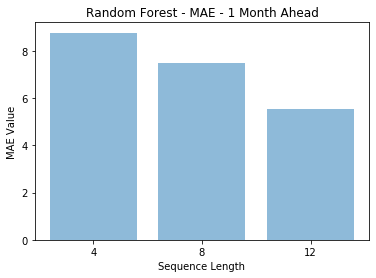

In [121]:
#querying the table for the 1 Month Ahead predictions with best mae in order

df_1 = df.select('Name', 'Sequence_Length', 'MAE').where(df.Name=='Random Forest').where(df.Months_Ahead==1).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

mae = df_pandas[['MAE']].values.tolist()
mae = list(np.array(mae).reshape(len(mae)))
print("\n\n\n")

#visualizing results for 1 month ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, mae, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('MAE Value')
plt.title('Random Forest - MAE - 1 Month Ahead')
#plt.savefig("D:/big_data/final_2/pics/Random Forest 1 MAE Month Ahead", transparent=True)
plt.show()

+-------------+---------------+---------+
|         Name|Sequence_Length|      MAE|
+-------------+---------------+---------+
|Random Forest|              4|10.759375|
|Random Forest|              8| 8.730808|
|Random Forest|             12|5.5710135|
+-------------+---------------+---------+







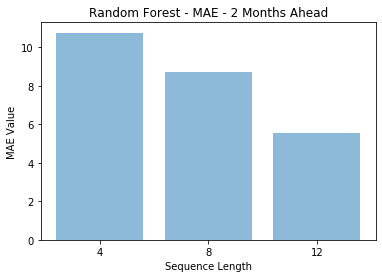

In [122]:
#querying the table for the 2 Months Ahead predictions with best mae in order

df_1 = df.select('Name', 'Sequence_Length', 'MAE').where(df.Name=='Random Forest').where(df.Months_Ahead==2).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

mae = df_pandas[['MAE']].values.tolist()
mae = list(np.array(mae).reshape(len(mae)))
print("\n\n\n")

#visualizing results for 2 months ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, mae, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('MAE Value')
plt.title('Random Forest - MAE - 2 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Random Forest MAE 2 Months Ahead", transparent=True)
plt.show()

+-------------+---------------+---------+
|         Name|Sequence_Length|      MAE|
+-------------+---------------+---------+
|Random Forest|              4|11.915256|
|Random Forest|              8| 8.913547|
|Random Forest|             12| 5.592274|
+-------------+---------------+---------+







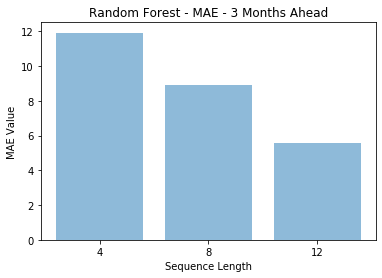

In [123]:
#querying the table for the 3 Months Ahead predictions with best mae in order

df_1 = df.select('Name', 'Sequence_Length', 'MAE').where(df.Name=='Random Forest').where(df.Months_Ahead==3).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

mae = df_pandas[['MAE']].values.tolist()
mae = list(np.array(mae).reshape(len(mae)))
print("\n\n\n")

#visualizing results for 3 months ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, mae, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('MAE Value')
plt.title('Random Forest - MAE - 3 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Random Forest MAE 3 Months Ahead", transparent=True)
plt.show()

+---------+---------------+---------+
|     Name|Sequence_Length|      MAE|
+---------+---------------+---------+
|Deep LSTM|              4| 7.019568|
|Deep LSTM|              8|6.7349434|
|Deep LSTM|             12|5.4174533|
+---------+---------------+---------+







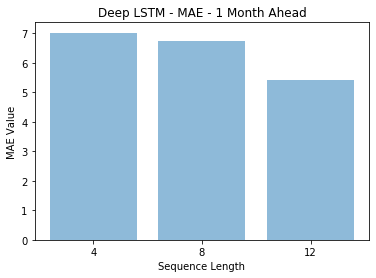

In [124]:
#querying the table for the 1 Month Ahead predictions with best mae in order

df_1 = df.select('Name', 'Sequence_Length', 'MAE').where(df.Name=='Deep LSTM').where(df.Months_Ahead==1).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

mae = df_pandas[['MAE']].values.tolist()
mae = list(np.array(mae).reshape(len(mae)))
print("\n\n\n")

#visualizing results for 1 month ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, mae, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('MAE Value')
plt.title('Deep LSTM - MAE - 1 Month Ahead')
#plt.savefig("D:/big_data/final_2/pics/Deep LSTM MAE 1 Month Ahead", transparent=True)
plt.show()

+---------+---------------+---------+
|     Name|Sequence_Length|      MAE|
+---------+---------------+---------+
|Deep LSTM|              4| 8.815583|
|Deep LSTM|              8|7.7642913|
|Deep LSTM|             12| 5.596985|
+---------+---------------+---------+







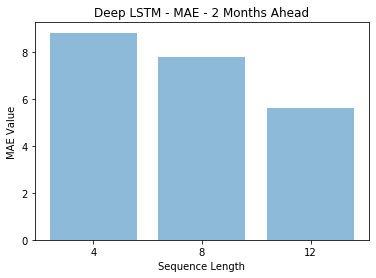

In [125]:
#querying the table for the 2 Months Ahead predictions with best mae in order

df_1 = df.select('Name', 'Sequence_Length', 'MAE').where(df.Name=='Deep LSTM').where(df.Months_Ahead==2).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

mae = df_pandas[['MAE']].values.tolist()
mae = list(np.array(mae).reshape(len(mae)))
print("\n\n\n")

#visualizing results for 1 month ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, mae, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('MAE Value')
plt.title('Deep LSTM - MAE - 2 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Deep LSTM MAE 2 Months Ahead", transparent=True)
plt.show()

+---------+---------------+---------+
|     Name|Sequence_Length|      MAE|
+---------+---------------+---------+
|Deep LSTM|              4| 9.788812|
|Deep LSTM|              8| 8.222333|
|Deep LSTM|             12|5.9033227|
+---------+---------------+---------+







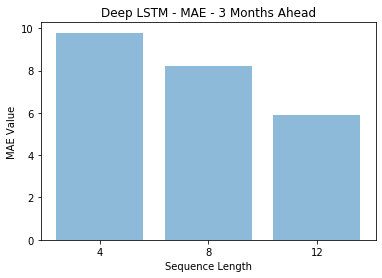

In [126]:
#querying the table for the 3 Months Ahead predictions with best mae in order

df_1 = df.select('Name', 'Sequence_Length', 'MAE').where(df.Name=='Deep LSTM').where(df.Months_Ahead==3).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

mae = df_pandas[['MAE']].values.tolist()
mae = list(np.array(mae).reshape(len(mae)))
print("\n\n\n")

#visualizing results for 3 months ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, mae, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('MAE Value')
plt.title('Deep LSTM - MAE - 3 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Deep LSTM MAE 3 Months Ahead", transparent=True)
plt.show()

+-------------+---------------+---------+
|         Name|Sequence_Length|     RMSE|
+-------------+---------------+---------+
|Random Forest|              4|14.819464|
|Random Forest|              8|13.254065|
|Random Forest|             12|9.9251795|
+-------------+---------------+---------+







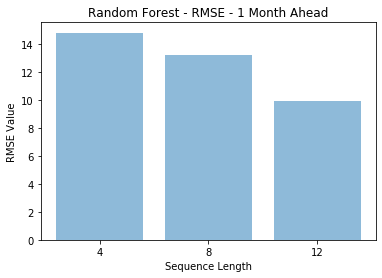

In [127]:
#querying the table for the 1 Month Ahead predictions with best rmse in order

df_1 = df.select('Name', 'Sequence_Length', 'RMSE').where(df.Name=='Random Forest').where(df.Months_Ahead==1).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

rmse = df_pandas[['RMSE']].values.tolist()
rmse = list(np.array(rmse).reshape(len(rmse)))
print("\n\n\n")

#visualizing results for 1 month ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, rmse, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('RMSE Value')
plt.title('Random Forest - RMSE - 1 Month Ahead')
#plt.savefig("D:/big_data/final_2/pics/Random Forest RMSE 1 Month Ahead", transparent=True)
plt.show()

+-------------+---------------+---------+
|         Name|Sequence_Length|     RMSE|
+-------------+---------------+---------+
|Random Forest|              4| 18.08007|
|Random Forest|              8|15.264706|
|Random Forest|             12| 9.933702|
+-------------+---------------+---------+







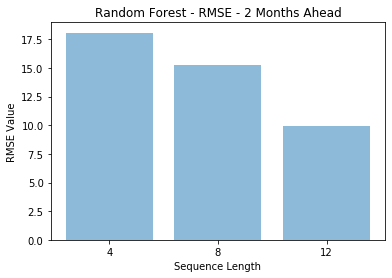

In [128]:
#querying the table for the 2 Months Ahead predictions with best rmse in order

df_1 = df.select('Name', 'Sequence_Length', 'RMSE').where(df.Name=='Random Forest').where(df.Months_Ahead==2).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

rmse = df_pandas[['RMSE']].values.tolist()
rmse = list(np.array(rmse).reshape(len(rmse)))
print("\n\n\n")

#visualizing results for 2 months ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, rmse, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('RMSE Value')
plt.title('Random Forest - RMSE - 2 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Random Forest RMSE 2 Months Ahead", transparent=True)
plt.show()

+-------------+---------------+---------+
|         Name|Sequence_Length|     RMSE|
+-------------+---------------+---------+
|Random Forest|              4|19.987394|
|Random Forest|              8| 15.68742|
|Random Forest|             12|10.000357|
+-------------+---------------+---------+







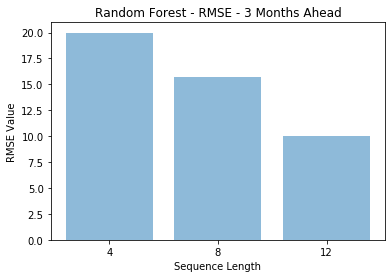

In [129]:
#querying the table for the 3 Months Ahead predictions with best rmse in order

df_1 = df.select('Name', 'Sequence_Length', 'RMSE').where(df.Name=='Random Forest').where(df.Months_Ahead==3).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

rmse = df_pandas[['RMSE']].values.tolist()
rmse = list(np.array(rmse).reshape(len(rmse)))
print("\n\n\n")

#visualizing results for 3 months ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, rmse, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('RMSE Value')
plt.title('Random Forest - RMSE - 3 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Random Forest RMSE 3 Months Ahead", transparent=True)
plt.show()

+---------+---------------+---------+
|     Name|Sequence_Length|     RMSE|
+---------+---------------+---------+
|Deep LSTM|              4|11.681969|
|Deep LSTM|              8|11.355647|
|Deep LSTM|             12| 9.272135|
+---------+---------------+---------+







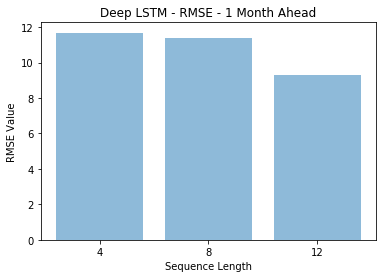

In [130]:
#querying the table for the 1 Month Ahead predictions with best rmse in order

df_1 = df.select('Name', 'Sequence_Length', 'RMSE').where(df.Name=='Deep LSTM').where(df.Months_Ahead==1).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

rmse = df_pandas[['RMSE']].values.tolist()
rmse = list(np.array(rmse).reshape(len(rmse)))
print("\n\n\n")

#visualizing results for 1 month ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, rmse, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('RMSE Value')
plt.title('Deep LSTM - RMSE - 1 Month Ahead')
#plt.savefig("D:/big_data/final_2/pics/Deep LSTM RMSE 1 Month Ahead", transparent=True)
plt.show()

+---------+---------------+----------+
|     Name|Sequence_Length|      RMSE|
+---------+---------------+----------+
|Deep LSTM|              4| 14.884027|
|Deep LSTM|              8|13.0495205|
|Deep LSTM|             12|  9.674221|
+---------+---------------+----------+







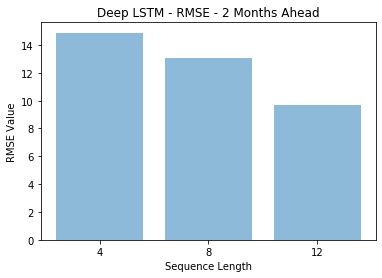

In [131]:
#querying the table for the 2 Months Ahead predictions with best rmse in order

df_1 = df.select('Name', 'Sequence_Length', 'RMSE').where(df.Name=='Deep LSTM').where(df.Months_Ahead==2).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

rmse = df_pandas[['RMSE']].values.tolist()
rmse = list(np.array(rmse).reshape(len(rmse)))
print("\n\n\n")

#visualizing results for 1 month ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, rmse, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('RMSE Value')
plt.title('Deep LSTM - RMSE - 2 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Deep LSTM RMSE 2 Months Ahead", transparent=True)
plt.show()

+---------+---------------+---------+
|     Name|Sequence_Length|     RMSE|
+---------+---------------+---------+
|Deep LSTM|              4| 16.25299|
|Deep LSTM|              8|13.661881|
|Deep LSTM|             12|10.049374|
+---------+---------------+---------+







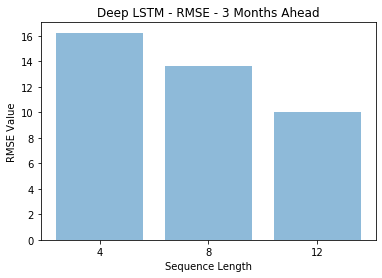

In [132]:
#querying the table for the 3 Months Ahead predictions with best mae in order

df_1 = df.select('Name', 'Sequence_Length', 'RMSE').where(df.Name=='Deep LSTM').where(df.Months_Ahead==3).orderBy('Sequence_Length')
df_1.show()

df_pandas = df_1.toPandas()

seq_length = df_pandas[['Sequence_Length']].values.tolist()
seq_length = list(np.array(seq_length).reshape(len(seq_length)))

rmse = df_pandas[['RMSE']].values.tolist()
rmse = list(np.array(rmse).reshape(len(rmse)))
print("\n\n\n")

#visualizing results for 3 months ahead of all sequence lengths
y_pos = np.arange(len(seq_length)) 
plt.bar(y_pos, rmse, align='center', alpha=0.5)
plt.xticks(y_pos, seq_length)
plt.xlabel('Sequence Length')
plt.ylabel('RMSE Value')
plt.title('Deep LSTM - RMSE - 3 Months Ahead')
#plt.savefig("D:/big_data/final_2/pics/Deep LSTM RMSE 3 Months Ahead", transparent=True)
plt.show()

In [133]:
spark_context.stop()